# Análise Exploratória Avançada

Census API: https://api.census.gov/data

endpoint(query): /2019/pep/population?get=NAME,DENSITY,POP&for=STATE:*

Manual: https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

# Análise Exploratória Avançada
### Decomposição Espectral e Análise de anomalias
* * *


Este notebook realiza uma análise exploratória nos dados americanos da COVID **por estado**.

* O objetivo é procurar por padrões no desenvolvimento da pandemia do COVID no território americano, por ambas dimensões temporal e espacial.

A variável de interesse estudada é a `deathIncrease` e os dados foram pre processados pelos scripts

    ./scripts
        |_ retrive_data_by_states.py # Busca dados da API Covid Tracking
        |_ retrive_data_census.py # Busca dados demográfico da API Census / PEP
        |_ processing_dta_by_states.py # Processa os dados para serem utilizados na EDA

**CONSIDERAÇÕES ADOTADAS**

* epidemias podem adotar um crescimento exponencial, o que significa que a taxa de contaminação é proporcional a quantidade **absoluta** de pessoas já contaminadas. Por estados possuirem diferentes tamanhos de população, esse fator pode interferir na análise. Assim a variavel criada é a "taxa de mortes p/ 100.000 habitantes" e com isso espera-se que distorções provenientes do tamanho da população nos estados seja amenizado.

* Os números de população são extraídos de:
    * Census API: https://api.census.gov/data
        * endpoints(query): /2019/pep/population?get=NAME,DENSITY,POP&for=STATE:*
        * Guia da API: Manual: https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

* Os dados cartográficos para **visualizações** usados podem ser obtidos em:
    * https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html#:~:text=A%20shapefile%20is%20a%20geospatial%20data%20format%20for,103rd%20through%20110th%20Congresses,%20see%20our%20FTP%20site.

**ANÁLISES REALIZADAS**

* **Decomposição Espectral**

A decomposição consiste transformar as séries temporais das taxas de mortes (p/ 100.000 habt.) **individuais** de cada estado em termos de algumas poucas séries temporais que seriam compartilhadas entre eles. Essas *séries* geradas são chamadas de *componentes* principais e através delas pode-se gerar atributos (escalares) que caracterizam os estados.

Esses atributos vão ser úteis para mineração ou mesmo para modelagem preditiva. Nesse caso, será avaliado o perfil de desenvolvimento da COVID nos estados. Com isso buscamos identifcar perfis de desenvolvimento da doença no território americano o que possibilita estratégias de modelagem preditiva mais específicas para cada perfil encontrado.

* **Análise de Clusterização**

Esta análise visa auxiliar no objetivo da decomposição espectral e descobrir anomalias, i.e., estados que devido ao seu perfil de doença poderia prejudicar a precisão dos modelos que usassem seus dados sem uma abordagem apropriada.

In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from resources.plotting import parallelplot
plt.style.use('ggplot')

In [2]:
def smoothen(arr, index):
    s = pd.Series(arr, index=index)
    stl = tsa.STL(s, period=7, seasonal=5).fit()
    return stl.trend.values

def plot_grid(nrows=1, ncols=1):
    width = ncols * 3.5 + 3.5
    height = nrows * 4.5 - (nrows - 1) * .3
    return plt.subplots(nrows, ncols, figsize=(width, height), constrained_layout=True)

In [3]:
all_states = pd.read_pickle('./data/dataframes/all_states.pkl').set_index('state')
index = pickle.load(open('data/index.pkl', 'rb'))

In [4]:
# Verificando a presença de NULL em alguma das séries dos
all_states['deathIncrease'].apply(lambda arr: np.any(np.isnan(arr))).any()

False

In [5]:
all_states = all_states.assign(deathInc_smooth = lambda df: df['deathIncrease'].apply(lambda arr: smoothen(arr, index=index)),
                deathIncRate_smooth = lambda df: df['deathInc_smooth'] / df['population'] * 1e5)

data = all_states['deathIncRate_smooth'].values

***

## Decomposição por Componentes Principais (PCA)

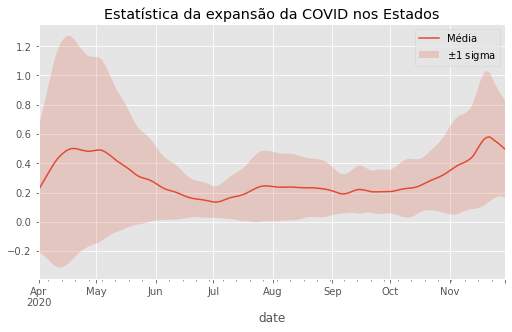

In [6]:
# Selecionando dados para PCA - Empilhando as séries verticalmente 
data = np.vstack(all_states['deathIncRate_smooth'])

# Standartização ()
data_scaled = StandardScaler(with_std=False).fit_transform(data)
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)

# Visualisando estatísticas básicas das séries
fig, ax = plot_grid()
ax = pd.Series(data_mean, index=index).plot(label='Média')
ax.set_title('Estatística da expansão da COVID nos Estados')
ax.fill_between(index, data_mean + data_std, data_mean - data_std, alpha=.2, label='$\pm$' +'1 sigma')
ax.legend();
# fig.savefig('data/imgs/mean_component.png', bbox_inches='tight')

Text(0.5, 1.0, 'Variância Retida na decomposição (%)')

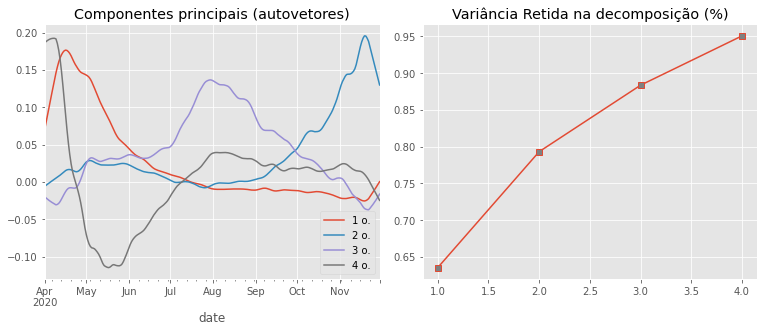

In [7]:
# Aplicando a decoposição linear dos autovetores
n_components = 4
pca = PCA(n_components = n_components).fit(data_scaled)

var_explained = np.cumsum(pca.explained_variance_ratio_)
componentes = pca.components_
#
fig, (ax1, ax2) = plot_grid(1,2)

for i, componente in enumerate(componentes, 1):
    pd.Series(componente, index=index).plot(ax=ax1, label='%d o.'%i)
ax1.set_title('Componentes principais (autovetores)')
ax1.legend()

ax2.plot(*zip(*enumerate(var_explained, 1)), marker='s', mfc='gray')
ax2.set_title('Variância Retida na decomposição (%)')

# fig.savefig('data/imgs/components.png', bbox_inches='tight')

<AxesSubplot:>

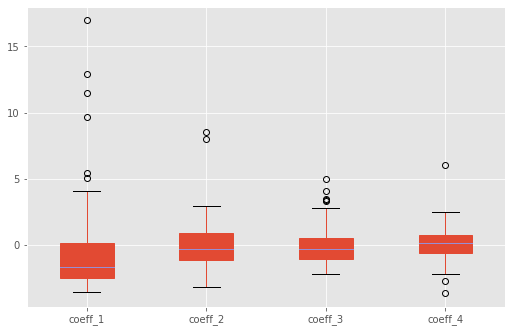

In [8]:
# decompondo as séries nas componentes principais (autovetores)
coeficientes = pca.transform(data_scaled)
decomp_dataframe = pd.DataFrame(coeficientes, columns=['coeff_%d'%i for i in range(1,4+1)], index=all_states.index)

# Visualizando a distribuição
fig, ax = plot_grid()
decomp_dataframe.boxplot(patch_artist=True, ax=ax)

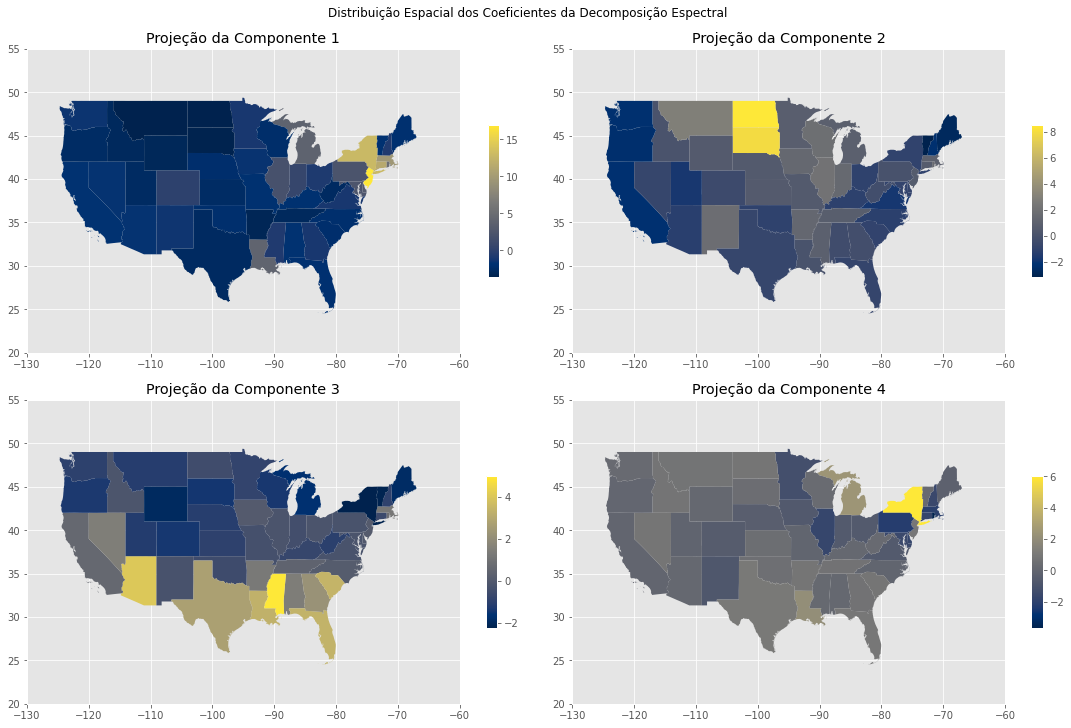

In [14]:
# Distribuição espacial dos coeficientes (projeções)

# carregando mapa
# fonte: https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
usa = gpd.read_file('./data/us/cb_2018_us_state_5m.shp') \
        .rename({'STATEFP':'fips', 'STUSPS':'state'}, axis=1).set_index('state').sort_index() \
        .loc[:,['fips', 'geometry']].merge(decomp_dataframe, on='state')

# visualizanddo projeções
fig, axs = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)
fig.suptitle('Distribuição Espacial dos Coeficientes da Decomposição Espectral')
for i, ax in enumerate(axs.ravel(), 1):
    ax.set_xlim(-130,-60)
    ax.set_ylim(20,55)
    ax.set_title('Projeção da Componente %d'%i)
    ax = usa.plot(column='coeff_%d'%i, cmap='cividis', ax=ax, legend=True, legend_kwds={'shrink':.5})

fig.savefig('data/imgs/projeçoes_estados.png', bbox_inches='tight')

In [10]:
# Avaliando os estados com 2n. Componente principal elevada
## Indicam um forte aumento na taxa de mortes no fim da série de dados

pop_tot = all_states['population'].sum()
decomp_dataframe.join(all_states[['population', 'name']]).sort_values('coeff_2', ascending=False) \
        .apply({'population': lambda s: (s/pop_tot*100).apply(lambda i: '%.2f%%'%(i)),
                'name': lambda s: s.upper(),
                'coeff_2': lambda x: x})[:10]

,population,name,coeff_2
state,,,
ND,0.23%,NORTH DAKOTA,8.522282
SD,0.27%,SOUTH DAKOTA,7.972939
MT,0.32%,MONTANA,2.898900
IL,3.82%,ILLINOIS,2.112808
WI,1.76%,WISCONSIN,1.877574
NM,0.63%,NEW MEXICO,1.784167
RI,0.32%,RHODE ISLAND,1.609230
IN,2.03%,INDIANA,1.499409
IA,0.95%,IOWA,1.484835


## Análise por Clusterização

Text(0.5, 0, '# of Clusters')

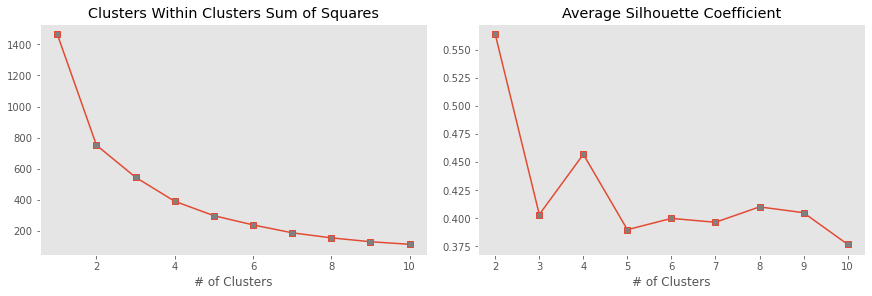

In [11]:
wcss = []
silhouette_values = []

for n in range(1,11):
    kmeans = KMeans(n_clusters=n, n_init=30).fit(decomp_dataframe)
    wcss.append(kmeans.inertia_)
    if n>1:
        silhouette_values.append(silhouette_score(decomp_dataframe, kmeans.labels_))

fig, axs = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)
axs[0].plot(range(1,11), wcss, marker='s', mfc='gray')
axs[0].set_title('Clusters Within Clusters Sum of Squares')
axs[1].plot(range(2,11), silhouette_values, marker='s', mfc='gray')
axs[1].set_title('Average Silhouette Coefficient')
axs[0].grid(lw=.5); axs[1].grid(lw=.5)
axs[0].set_xlabel('# of Clusters'); axs[1].set_xlabel('# of Clusters')

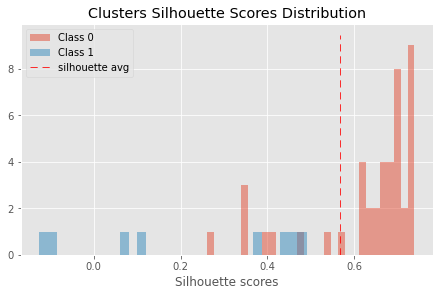

In [12]:
# the unmber of clusters chosen
n_cluster= 2
kmeans = KMeans(n_clusters=n_cluster, n_init=30, random_state=1511).fit(decomp_dataframe)
decomp_dataframe = decomp_dataframe.assign(cluster = kmeans.labels_)

# diagnóstico da clusterição

silh_avg = silhouette_score(decomp_dataframe, kmeans.labels_)
silh_scores = silhouette_samples(decomp_dataframe, kmeans.labels_)

# plotting
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
for i in range(n_cluster):
    ax.hist(silh_scores[kmeans.labels_ == i], bins=30, label='Class %d'%i, alpha=.5)
ax.vlines(silh_avg, 0, max(plt.gca().get_ylim()), ls=(0,(9, 6)), color='r', lw=.8, label='silhouette avg')
ax.set_xlabel('Silhouette scores')
ax.set_title('Clusters Silhouette Scores Distribution')
ax.legend()

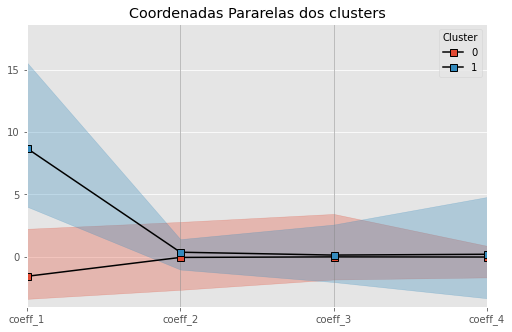

In [13]:
fig, ax = plot_grid()
parallelplot(decomp_dataframe.assign(cluster=kmeans.labels_), 
                                category='cluster',
                                centroids=True,
                                interval='robust', alpha=.3, ax=ax)

ax.set_title('Coordenadas Pararelas dos clusters')
fig.savefig('data/imgs/clsuters_parall_plot.png', bbox_inches='tight')

### CONCLUSÕES

* Decomposição por componentes principais

A análise dos componentes principais encontros 4 autovetores que juntos explicam ~95% da variância entre as séries temporais das taxas de morte nos estados.

| Componente Principal (no. Autovetor) | Interpretação |
| --- | --- |
| 1 | Tende a gerar um pico de mortes no início |
| 2 | Tende a gerar um pico de mortes no final |
| 3 | Gera um aumento substancial no meio do ano (verão) |
| 4 | Indica uma reposta rápida a pandemia já no seu início |

Em seguida as séries temporadas dos estados foram projetadas nos componentes principais para se produzir a caracterizaçào de cada estado em relação a evolução da taxa de mortes nele.

A distribuição dos valores das projeções de cada estado (coeficientes) não apresentou muita variação.

Uma análise por clusterização foi realizada para uma avaliação mais detalhada.

* Clusterização (Kmeans)

A clusterização sugere a presença de 2 agrupamentos, mas não indica segmentos diferentes dentro do data set.
Dessa forma a análise está apenas detectando anomalias que alguns estados tiveram no início da pandemia já que as anomalias dizem respeito a 1a. componene principal apenas.

***

#### Bottomline

Em se tratando de previsão de modelagem, a maioria dos estados apresentam uma aderência à média nacional no índice de taxa de mortes (p/ 100.000 hab.). 

Alguns estados no apresentaram um alta magnitude na componente responsável por aumentar o número de morte ao final da série, em divergência com o restante do país, no entanto seu peso nos números absolutes pode ser pequeno devido a sua baixa população. Assim o índice nacional pode ser considerado um preditor para a taxa de mortes por covid.

Os número nacionais são muito dispersos nos primeiros meses da COVID, e isso pode prejudicar a precisão das previsões.


In [26]:
pd.DataFrame.filter?

In [30]:
usa.assign(maxComp = np.argmax(usa.filter(regex=r'[0-9]$', axis=1)))

,fips,geometry,coeff_1,coeff_2,coeff_3,coeff_4,cluster,maxComp
state,,,,,,,,
AK,02,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",-2.792075,-2.171934,-1.688134,0.131691,0,124
AL,01,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...",-1.698707,-0.347712,1.445640,0.124620,0,124
AR,05,"POLYGON ((-94.61792 36.49941, -94.55929 36.499...",-3.097453,1.364379,1.288861,0.864409,0,124
AZ,04,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",-1.643354,-1.264360,4.047061,0.173368,0,124
CA,06,"MULTIPOLYGON (((-118.60337 33.47810, -118.5987...",-1.704553,-2.212906,0.631210,0.019342,0,124
CO,08,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",-0.006366,-0.491199,-1.375647,-0.462332,0,124
CT,09,"POLYGON ((-73.72777 41.10070, -73.69595 41.115...",11.452363,0.673288,-0.629491,-1.662686,1,124
DC,11,"POLYGON ((-77.11976 38.93434, -77.10450 38.946...",5.392605,-1.063000,0.078607,-2.732580,1,124
DE,10,"MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ...",2.882406,-0.831171,0.002720,-1.692892,0,124


(20.0, 55.0)

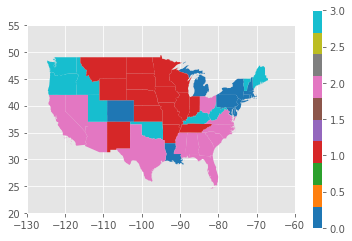

In [35]:
ax = usa.assign(maxComp = np.argmax(usa.filter(regex=r'[0-9]$', axis=1).values, axis=1)).plot(column='maxComp', legend=True, cmap='tab10')
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)